In [1]:
import os
import yaml

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr, compare_clusters, u_stats, plot

In [2]:
# specify VAE20 clustering and associated window size and latent dimension
# vae_output_dir, clustering, window_size, latent_dim = ('VAE20', 'VAE20', 30, 850)
# # specify cluster pairs
# pairs = [(12, 15)]

vae_output_dir, clustering, window_size, latent_dim = ('VAE9_VIG7', 'VAE9_VIG7', 14, 412)
# specify cluster pairs
pairs = [(18, 22)]

In [3]:
# I/O
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# image contrast settings
contrast_limits = yaml.safe_load(open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')))

antibody_abbrs = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

root = os.path.join(os.getcwd(), f'input/{vae_output_dir}')

# read combined training, validation, and test thumbnails
X_combo = zarr.open(os.path.join(root, f'6_latent_space_LD{latent_dim}/combined_zarr'))

# rearrange Zarr dimensions to conform to expected VAE input (i.e. cells, x, y, channels)
X_combo = transposeZarr(z=X_combo)

# output directory
out = os.path.join(os.getcwd(), f'output/img_similarity')
if not os.path.exists(out):
    os.makedirs(out)


(18, 22)


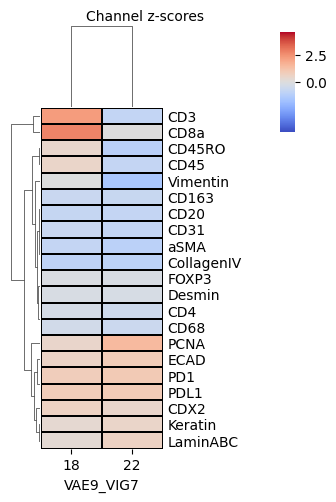

MSE U-stats:
      u-stat           pval  plot_ch
0   366711.0   0.000000e+00        0
5   576577.0  1.928116e-210        1
9   530672.0  5.865640e-231        2
19  852832.0  2.862118e-107        3



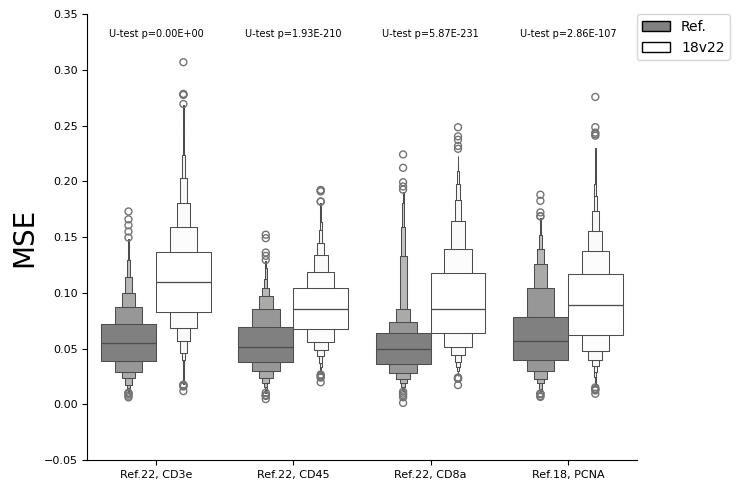

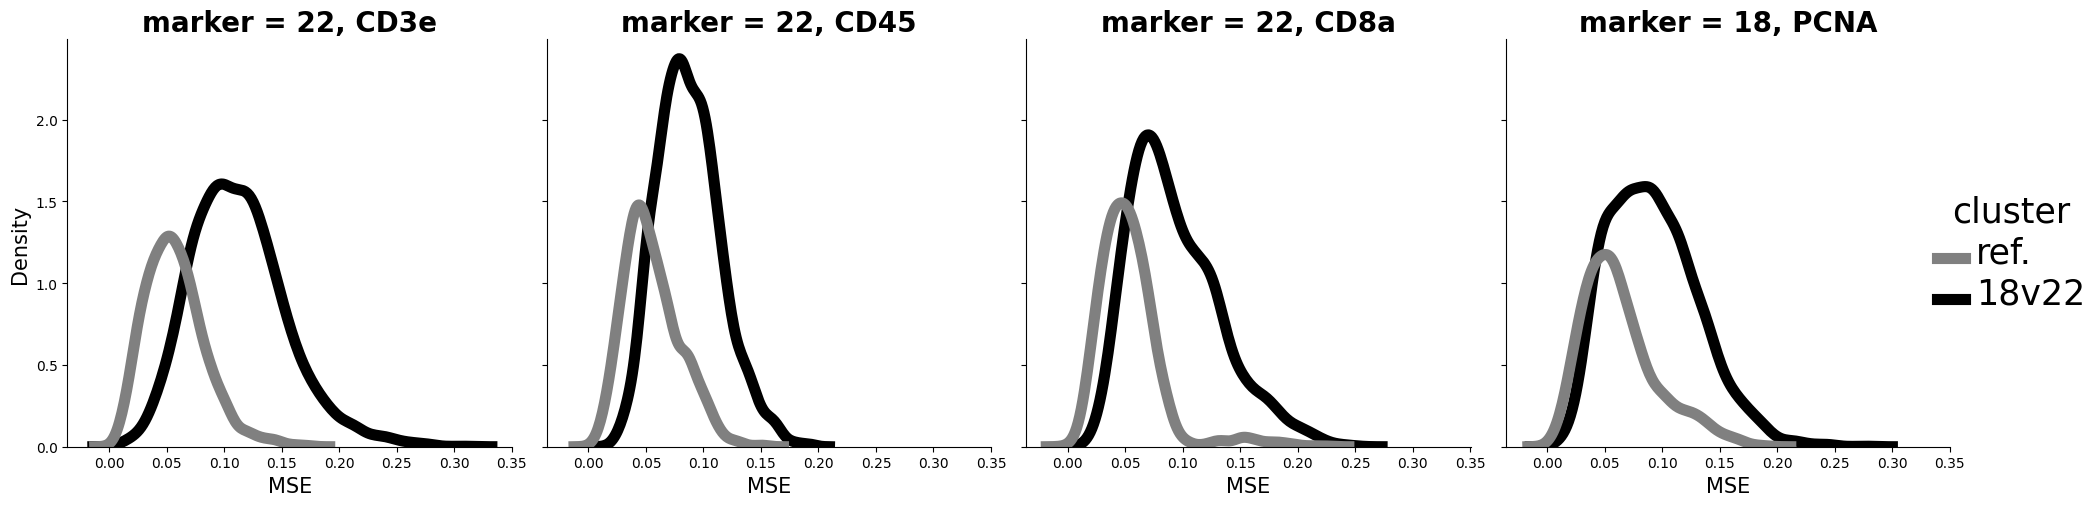

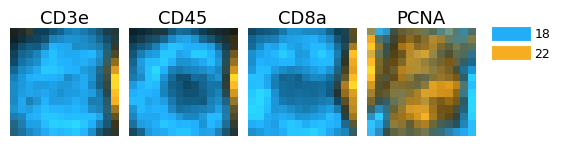

In [4]:
# compute median values of per patch, per channel pixel intensity medians
medians = da.median(X_combo, axis=(1, 2)).compute()
clustermap_input = pd.DataFrame(columns=[i for i in antibody_abbrs.keys()], data=medians)
clustermap_input[clustering] = main[clustering]
clustermap_input = clustermap_input.groupby(clustering).median()

# compute per channel z-scores across clusters
clustermap_input = (clustermap_input-clustermap_input.mean())/clustermap_input.std()

# zero-center colorbar
norm = TwoSlopeNorm(vcenter=0, vmin=clustermap_input.min().min(), vmax=clustermap_input.max().max())

print()
channels = {'CD3e': 0, 'CD45': 5, 'CD8a' : 9, 'PCNA': 19}
for clus_pair in pairs:

    print(clus_pair)

    combo_label = f'{clus_pair[0]}v{clus_pair[1]}'

    save_dir = os.path.join(out, combo_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    clustermap_subset = clustermap_input[clustermap_input.index.isin(clus_pair)]

    g = sns.clustermap(
        clustermap_subset.T, cmap='coolwarm', standard_scale=None, yticklabels=1, xticklabels=1,
        linewidths=0.1, linecolor='k', cbar=True, norm=norm, figsize=(3, 5) 
    )
    g.ax_heatmap.set_xticklabels(
        [i.get_text() for i in g.ax_heatmap.get_xticklabels()], rotation=0
    )
    g.ax_heatmap.set_yticklabels(
        [antibody_abbrs[i.get_text()] for i in g.ax_heatmap.get_yticklabels()], rotation=0
    )
    g.ax_cbar.set_position([0.95, 0.75, 0.05, 0.2])
    g.fig.suptitle('Channel z-scores', y=0.995, fontsize=10)
    g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)
    plt.savefig(os.path.join(save_dir, 'channel_z-scores.pdf'), bbox_inches='tight')
    plt.show()

    # get positional indices of clustering cells (aligned with X_combo)
    clus1_idxs = main.index[main[clustering] == clus_pair[0]]
    clus2_idxs = main.index[main[clustering] == clus_pair[1]]

    # take subsets
    clus1_idxs = clus1_idxs[0:50]
    clus2_idxs = clus2_idxs[0:50]

    for metric in ['MSE']:

        df, cluster_select, sq_err = compare_clusters(
            clus1_name=clus_pair[0], clus1_idxs=clus1_idxs,
            clus2_name=clus_pair[1], clus2_idxs=clus2_idxs,
            metric=metric, channels=channels,
            X_combo=X_combo, combo_label=combo_label,
            save_dir=save_dir, window_size=window_size
        )
    
        # save dataframe with metric values
        df.reset_index(drop=True, inplace=True)
        df.to_csv(os.path.join(save_dir, f'{metric}.csv'), index=False)

        # create dataframe of stored t-test stats
        stats = u_stats(
            df=df, metric=metric, cluster_select=cluster_select,
            channels=channels, combo_label=combo_label
        )

        # plot metric data
        plot(
            df=df, metric=metric, stats=stats, sq_err=sq_err,
            combo_label=combo_label, clus_pair=clus_pair, save_dir=save_dir
        )